# Usage with Cylc workflow manager and conda

The command line interface can be used with workflow managers like cylc and conda environments.

## Prerequisites

This example requires a conda environment called `autora-cylc` with the following dependencies:
- `autora` 3+
- `cylc-flow`

The conda environment will be cloned during the setup phase of the `cylc` workflow run.

You can initialize the conda environment using the included environment.yml file.
```shell
conda env create -f environment.yml
```

To run this code from the notebook directly, you need to activate the `autora-core` ipython kernel from jupyter.
Once you've activated the environment, install the kernel as follows:
```shell
python -m ipykernel install --user
```

## Workflow

To initialize the workflow, we again define a file `lib.py` with the code for the experiment, this time in the
`lib/python` directory [(a cylc convention)](https://cylc.github.io/cylc-doc/stable/html/user-guide/writing-workflows/configuration.html#workflow-configuration-directories):

In [1]:
# Display the contents of the file here
!pygmentize lib/python/func0.py

import numpy as np
from autora.experimentalist.pipeline import (
    make_pipeline as make_experimentalist_pipeline,
)
from autora.variable import Variable, VariableCollection
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline as make_theorist_pipeline
from sklearn.preprocessing import PolynomialFeatures

from autora.workflow import Controller

rng = np.random.default_rng(180)

experimentalist = make_experimentalist_pipeline(
    [np.linspace, rng.choice],
    params={
        "linspace": {"start": [-10], "stop": [+10], "num": 1001},
        "choice": {"size": 10},
    },
)

coefs = [2.0, 3.0, 1.0]
noise_std = 10.0


def experiment_runner(x, coefs_=coefs, noise_std_=noise_std, rng=rng):
    """Simple experiment."""
    x_ = np.array(x)  # assume we've got an array already
    y_ = (
        coefs_[0] * x_**2.0
        + coefs_[1] * x_
        + coefs_[2]
        + rng.normal(0.0, noise_std_, size

Then, before we start the experiment, we
- load the controller from the file
- save its state to a `.dill` file.

In [5]:
# Add the lib/python directory to the current path, so that we can import func0 in this notebook
import sys, os
sys.path.insert(0, os.path.abspath('lib/python'))

In [6]:
import dill
from func0 import controller
with open("controller.dill", "wb") as file:
    dill.dump(controller, file)

The `flow.cylc` file defines the workflow:

In [7]:
!cat "flow.cylc"

[runtime]
    [[setup]]
        script = """
            cp $CYLC_WORKFLOW_RUN_DIR/controller.dill $CYLC_WORKFLOW_SHARE_DIR;
            conda create -p $CYLC_WORKFLOW_SHARE_DIR/env --clone autora-cylc
        """
    [[experimentalist]]
        script = """
            $CYLC_WORKFLOW_SHARE_DIR/env/bin/python -m autora.workflow \
                "$CYLC_WORKFLOW_SHARE_DIR/controller.dill" \
                "$CYLC_WORKFLOW_SHARE_DIR/controller.dill" \
                experimentalist \
                --debug
        """
    [[experiment_runner]]
        script = """
            $CYLC_WORKFLOW_SHARE_DIR/env/bin/python -m autora.workflow \
                "$CYLC_WORKFLOW_SHARE_DIR/controller.dill" \
                "$CYLC_WORKFLOW_SHARE_DIR/controller.dill" \
                experiment_runner \
                --debug
        """
    [[theorist]]
        script = """
            $CYLC_WORKFLOW_SHARE_DIR/env/bin/python -m autora.workflow \
                "$CYLC_WORKFLOW_SHARE_DIR/controlle

We can call the `cylc` command line interface as follows. (Run these commands in a separate terminal window.)
First, we validate the `flow.cylc` file:
```shell
cylc validate .
```

We install the workflow:
```shell
cylc install .
```

We tell cylc to play the workflow:
```shell
cylc play "with-cylc-conda"
```

(As a shortcut for "validate, install and play", use `cylc vip .`)

We can view the workflow running in the graphical user interface (GUI):
```shell
cylc gui
```

... or the text user interface (TUI):
```shell
cylc tui "with-cylc-conda"
```


You can load and interrogate the resulting object as follows:


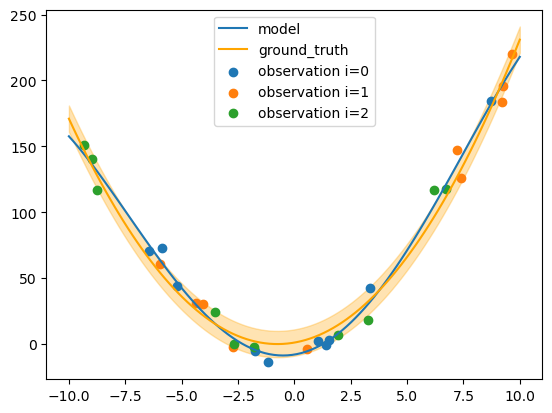

In [14]:
import numpy as np
from matplotlib import pyplot as plt

from func0 import experiment_runner as ground_truth, noise_std

def plot_results(controller_):
    last_model = controller_.state.filter_by(kind={"MODEL"}).history[-1].data

    x = np.linspace(-10, 10, 100).reshape((-1, 1))

    plt.plot(x, last_model.predict(x), label="model")

    plt.plot(x, ground_truth(x, noise_std_=0.), label="ground_truth", c="orange")
    plt.fill_between(x.flatten(), ground_truth(x, noise_std_=0.).flatten() + noise_std, ground_truth(x, noise_std_=0.).flatten() - noise_std,
                     alpha=0.3, color="orange")

    for i, observation in enumerate(controller_.state.filter_by(kind={"OBSERVATION"}).history):
        xi, yi = observation.data[:,0], observation.data[:,1]
        plt.scatter(xi, yi, label=f"observation {i=}")
    plt.legend()

with open(os.path.expanduser("~/cylc-run/with-cylc-conda/runN/share/controller.dill"),"rb") as file:
    controller_result = dill.load(file)

plot_results(controller_result)
